# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_191  P19320            16.050
Sample_190  Q6UX72            15.430
Sample_080  P13489            14.867
Sample_020  Q8N967            15.016
Sample_050  Q8N2Q7;Q8N2Q7-2   16.639
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups 
Sample_026  A0A0A0MT66        14.503
Sample_104  Q14956;Q14956-2   13.953
Sample_081  H0Y7C8;O14657     10.796
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.622
            A0A075B6Q5                 12.427
            A0A075B6R2                 12.437
            A0A075B6S5                 12.487
            A0A087WSY4                 13.385
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.724
            Q9UI40;Q9UI40-2            13.540
            Q9UIW2                     13.879
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.379
            Q9UP79                     13.151
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.570,15.050,16.842,19.863,16.183,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.388,19.067,...,15.528,15.576,14.695,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.745,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.975,17.705,17.039,15.405,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.433,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,15.222,15.345,17.084,18.708,14.249,19.433,11.938,10.843
Sample_207,15.739,16.877,15.469,16.898,15.160,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,11.542,12.936,13.643,12.217,10.797,12.412,13.956,12.206,12.925,11.843
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.477,19.067,16.127,...,11.230,13.007,13.723,12.561,13.495,12.770,13.005,12.891,12.147,13.104
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.195,13.054,13.949,12.461,11.884,12.525,12.797,13.358,13.021,14.748
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,11.801,13.473,13.383,12.139,13.111,12.426,13.550,13.829,13.992,12.355
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.155,13.133,13.942,13.080,13.195,11.438,12.102,13.375,13.322,11.276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.542,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 166.80it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.94it/s]

100%|██████████| 3/3 [00:00<00:00,  3.82it/s]

100%|██████████| 3/3 [00:00<00:00,  4.00it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.30it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.52it/s]

100%|██████████| 4/4 [00:00<00:00,  3.86it/s]

100%|██████████| 4/4 [00:00<00:00,  4.13it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.77it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.67it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.98it/s]

100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

100%|██████████| 5/5 [00:01<00:00,  4.06it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.80it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.14it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.23it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.75it/s]

100%|██████████| 6/6 [00:01<00:00,  2.61it/s]

100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.96it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.51it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.74it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.65it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.83it/s]

100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.29it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.29it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.74it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.58it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.20it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.86it/s]

100%|██████████| 8/8 [00:02<00:00,  2.63it/s]

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.73it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.45it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.42it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.39it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.29it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.25it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.15it/s]

100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

100%|██████████| 9/9 [00:02<00:00,  3.40it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.23it/s]

 30%|███       | 3/10 [00:00<00:01,  5.22it/s]

 40%|████      | 4/10 [00:00<00:01,  3.94it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.88it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.52it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.46it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.39it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.38it/s]

100%|██████████| 10/10 [00:02<00:00,  3.56it/s]

100%|██████████| 10/10 [00:02<00:00,  3.78it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.89it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.93it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.00it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.68it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.06it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.89it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.58it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.48it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.45it/s]

100%|██████████| 11/11 [00:02<00:00,  3.69it/s]

100%|██████████| 11/11 [00:02<00:00,  4.05it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.83it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.65it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.41it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.92it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.75it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.93it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.92it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.17it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.29it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.17it/s]

100%|██████████| 12/12 [00:02<00:00,  4.11it/s]

100%|██████████| 12/12 [00:02<00:00,  4.24it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.98it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.21it/s]

 31%|███       | 4/13 [00:00<00:02,  4.14it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.91it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.84it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.84it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.77it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.76it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.75it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.89it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.68it/s]

100%|██████████| 13/13 [00:03<00:00,  3.86it/s]

100%|██████████| 13/13 [00:03<00:00,  4.03it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.80it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.16it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.82it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.72it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.76it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.00it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.16it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  4.16it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.18it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.22it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.26it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  4.25it/s]

100%|██████████| 14/14 [00:03<00:00,  4.29it/s]

100%|██████████| 14/14 [00:03<00:00,  4.19it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.07it/s]

 20%|██        | 3/15 [00:00<00:02,  4.62it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.39it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.98it/s]

 40%|████      | 6/15 [00:01<00:02,  3.92it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.81it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.87it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.80it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.88it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.01it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.99it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  4.11it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.02it/s]

100%|██████████| 15/15 [00:03<00:00,  3.67it/s]

100%|██████████| 15/15 [00:03<00:00,  3.99it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.002      0.052 0.019          0.650 0.423       0.088   
2             0.006 0.002      0.063 0.024          0.814 0.083       0.726   
3             0.004 0.002      0.047 0.015          0.800 0.077       0.719   
4             0.005 0.002      0.050 0.021          0.806 0.088       0.786   
5             0.006 0.003      0.058 0.024          0.816 0.092       0.785   
6             0.005 0.002      0.048 0.016          0.816 0.094       0.757   
7             0.006 0.003      0.057 0.026          0.810 0.089       0.756   
8             0.005 0.003      0.054 0.021          0.795 0.090       0.754   
9             0.006 0.003      0.062 0.028          0.794 0.079       0.830   
10            0.004 0.001      0.040 0.009          0.792 0.078       0.826   
11            0.004 0.001      0.039 0.008          0.788 0.084       0.825   
12            0.004 0.002      0.041 0.016          0.808 0.080       0.855   
13            0.004 0.002      0.042 0.013          0.822 0.077       0.853   
14            0.004 0.002      0.044 0.015          0.817 0.084       0.832   
15            0.004 0.001      0.039 0.008          0.813 0.084       0.831   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.149 0.126                  0.537 0.039        0.856   
2          0.125   0.762 0.090                  0.802 0.067        0.868   
3          0.122   0.752 0.087                  0.794 0.067        0.869   
4          0.116   0.791 0.086                  0.823 0.071        0.882   
5          0.115   0.796 0.086                  0.827 0.070        0.883   
6          0.117   0.780 0.088                  0.815 0.071        0.886   
7          0.114   0.777 0.085                  0.812 0.067        0.885   
8          0.110   0.769 0.085                  0.805 0.068        0.886   
9          0.105   0.807 0.072                  0.835 0.061        0.910   
10         0.108   0.804 0.072                  0.833 0.061        0.907   
11         0.114   0.801 0.079                  0.830 0.066        0.907   
12         0.090   0.827 0.066                  0.852 0.058        0.918   
13         0.089   0.833 0.063                  0.857 0.055        0.918   
14         0.101   0.821 0.073                  0.847 0.063        0.915   
15         0.101   0.818 0.073                  0.844 0.063        0.913   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.058                  0.825 0.085        210.000 0.000  
2          0.061                  0.853 0.073        210.000 0.000  
3          0.057                  0.856 0.065        210.000 0.000  
4          0.064                  0.876 0.066        210.000 0.000  
5          0.061                  0.876 0.064        210.000 0.000  
6          0.059                  0.876 0.065        210.000 0.000  
7          0.059                  0.875 0.065        210.000 0.000  
8          0.061                  0.876 0.065        210.000 0.000  
9          0.051                  0.897 0.054        210.000 0.000  
10         0.052                  0.893 0.054        210.000 0.000  
11         0.051                  0.895 0.053        210.000 0.000  
12         0.049                  0.909 0.051        210.000 0.000  
13         0.048                  0.906 0.051        210.000 0.000  
14         0.048                  0.901 0.052        210.000 0.000  
15         0.049                  0.900 0.053 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 235.21it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.10it/s]

100%|██████████| 3/3 [00:00<00:00,  5.18it/s]

100%|██████████| 3/3 [00:00<00:00,  5.57it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.31it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.95it/s]

100%|██████████| 4/4 [00:01<00:00,  3.56it/s]

100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.88it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.46it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.83it/s]

100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

100%|██████████| 5/5 [00:01<00:00,  3.35it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.40it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.23it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.59it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.17it/s]

100%|██████████| 6/6 [00:01<00:00,  3.10it/s]

100%|██████████| 6/6 [00:01<00:00,  3.42it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.82it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.08it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.76it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.92it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  5.27it/s]

100%|██████████| 7/7 [00:01<00:00,  5.13it/s]

100%|██████████| 7/7 [00:01<00:00,  5.22it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  9.58it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.58it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.77it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.38it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.94it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.68it/s]

100%|██████████| 8/8 [00:01<00:00,  3.70it/s]

100%|██████████| 8/8 [00:01<00:00,  4.21it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  9.16it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.26it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.03it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.79it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.67it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.57it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.62it/s]

100%|██████████| 9/9 [00:01<00:00,  4.55it/s]

100%|██████████| 9/9 [00:01<00:00,  4.91it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.30it/s]

 30%|███       | 3/10 [00:00<00:01,  5.08it/s]

 40%|████      | 4/10 [00:00<00:01,  4.52it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.09it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.99it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.85it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.85it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.82it/s]

100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.55it/s]

 27%|██▋       | 3/11 [00:00<00:01,  7.42it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.72it/s]

 45%|████▌     | 5/11 [00:00<00:00,  6.23it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  5.96it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  6.07it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  6.09it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  6.16it/s]

 91%|█████████ | 10/11 [00:01<00:00,  6.05it/s]

100%|██████████| 11/11 [00:01<00:00,  6.00it/s]

100%|██████████| 11/11 [00:01<00:00,  6.27it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.85it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.32it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.57it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.25it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.86it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.73it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.01it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.98it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.07it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.38it/s]

100%|██████████| 12/12 [00:02<00:00,  4.29it/s]

100%|██████████| 12/12 [00:02<00:00,  4.30it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01, 10.24it/s]

 31%|███       | 4/13 [00:00<00:01,  5.80it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.16it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.74it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.55it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.41it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.36it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.30it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.47it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.52it/s]

100%|██████████| 13/13 [00:02<00:00,  4.53it/s]

100%|██████████| 13/13 [00:02<00:00,  4.75it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 12.47it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.56it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.93it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.71it/s]

 50%|█████     | 7/14 [00:00<00:01,  6.68it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.38it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  6.46it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  6.81it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  7.05it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  7.06it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  7.21it/s]

100%|██████████| 14/14 [00:01<00:00,  7.36it/s]

100%|██████████| 14/14 [00:01<00:00,  7.12it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 13.01it/s]

 27%|██▋       | 4/15 [00:00<00:01,  7.80it/s]

 33%|███▎      | 5/15 [00:00<00:01,  7.20it/s]

 40%|████      | 6/15 [00:00<00:01,  6.86it/s]

 47%|████▋     | 7/15 [00:00<00:01,  6.62it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.80it/s]

 60%|██████    | 9/15 [00:01<00:00,  6.54it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  6.40it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  6.26it/s]

 80%|████████  | 12/15 [00:01<00:00,  6.04it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  6.08it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  5.88it/s]

100%|██████████| 15/15 [00:02<00:00,  5.86it/s]

100%|██████████| 15/15 [00:02<00:00,  6.51it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.041 0.010          0.087 0.248       0.009   
2             0.004 0.001      0.039 0.008          0.703 0.122       0.547   
3             0.004 0.002      0.038 0.007          0.723 0.116       0.576   
4             0.006 0.003      0.057 0.025          0.693 0.111       0.574   
5             0.006 0.003      0.057 0.021          0.726 0.090       0.681   
6             0.004 0.002      0.036 0.009          0.736 0.095       0.672   
7             0.002 0.000      0.022 0.005          0.795 0.105       0.784   
8             0.004 0.000      0.034 0.002          0.798 0.105       0.782   
9             0.003 0.001      0.029 0.006          0.798 0.104       0.785   
10            0.004 0.001      0.034 0.006          0.820 0.092       0.791   
11            0.003 0.001      0.027 0.005          0.831 0.090       0.802   
12            0.004 0.000      0.032 0.004          0.836 0.093       0.805   
13            0.003 0.001      0.027 0.006          0.846 0.086       0.811   
14            0.002 0.000      0.020 0.000          0.852 0.084       0.825   
15            0.002 0.000      0.021 0.000          0.849 0.085       0.823   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.017 0.048                  0.501 0.012        0.866   
2          0.132   0.605 0.107                  0.684 0.076        0.748   
3          0.131   0.630 0.097                  0.702 0.070        0.744   
4          0.127   0.619 0.098                  0.690 0.071        0.740   
5          0.104   0.698 0.079                  0.745 0.064        0.817   
6          0.106   0.697 0.080                  0.746 0.063        0.815   
7          0.103   0.784 0.080                  0.815 0.067        0.906   
8          0.099   0.784 0.076                  0.816 0.064        0.905   
9          0.104   0.786 0.082                  0.818 0.068        0.902   
10         0.099   0.800 0.069                  0.830 0.057        0.922   
11         0.109   0.810 0.072                  0.838 0.059        0.927   
12         0.108   0.814 0.073                  0.842 0.060        0.927   
13         0.107   0.823 0.075                  0.850 0.062        0.930   
14         0.111   0.833 0.075                  0.858 0.062        0.930   
15         0.112   0.830 0.074                  0.856 0.061        0.930   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.835 0.087        210.000 0.000  
2          0.078                  0.679 0.100        210.000 0.000  
3          0.079                  0.675 0.099        210.000 0.000  
4          0.079                  0.671 0.099        210.000 0.000  
5          0.063                  0.782 0.079        210.000 0.000  
6          0.062                  0.782 0.079        210.000 0.000  
7          0.046                  0.888 0.057        210.000 0.000  
8          0.047                  0.886 0.059        210.000 0.000  
9          0.049                  0.884 0.059        210.000 0.000  
10         0.040                  0.903 0.052        210.000 0.000  
11         0.042                  0.905 0.053        210.000 0.000  
12         0.042                  0.907 0.052        210.000 0.000  
13         0.040                  0.910 0.050        210.000 0.000  
14         0.040                  0.909 0.050        210.000 0.000  
15         0.040                  0.910 0.050 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1093.69it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 58.73it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 48.81it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 42.52it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 38.99it/s]

100%|██████████| 5/5 [00:00<00:00, 38.73it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 41.59it/s]

100%|██████████| 6/6 [00:00<00:00, 39.92it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 42.97it/s]

100%|██████████| 7/7 [00:00<00:00, 39.25it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 42.46it/s]

100%|██████████| 8/8 [00:00<00:00, 37.80it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 41.07it/s]

100%|██████████| 9/9 [00:00<00:00, 37.40it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 40.06it/s]

100%|██████████| 10/10 [00:00<00:00, 36.58it/s]

100%|██████████| 10/10 [00:00<00:00, 36.95it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 41.73it/s]

 91%|█████████ | 10/11 [00:00<00:00, 36.60it/s]

100%|██████████| 11/11 [00:00<00:00, 36.66it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 39.98it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 35.47it/s]

100%|██████████| 12/12 [00:00<00:00, 35.31it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 40.42it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 35.46it/s]

100%|██████████| 13/13 [00:00<00:00, 35.01it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 40.78it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 35.91it/s]

100%|██████████| 14/14 [00:00<00:00, 34.78it/s]

100%|██████████| 14/14 [00:00<00:00, 35.47it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 42.07it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 36.31it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 34.77it/s]

100%|██████████| 15/15 [00:00<00:00, 35.37it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.021 0.001          0.000 0.000       0.000   
2             0.002 0.000      0.021 0.001          0.671 0.108       0.514   
3             0.002 0.000      0.020 0.001          0.661 0.109       0.517   
4             0.002 0.000      0.020 0.000          0.720 0.082       0.650   
5             0.002 0.000      0.020 0.000          0.710 0.082       0.649   
6             0.002 0.000      0.020 0.000          0.719 0.073       0.638   
7             0.002 0.000      0.020 0.000          0.695 0.073       0.637   
8             0.002 0.000      0.020 0.000          0.683 0.076       0.628   
9             0.002 0.000      0.021 0.001          0.685 0.074       0.640   
10            0.002 0.000      0.020 0.000          0.684 0.075       0.638   
11            0.002 0.000      0.020 0.000          0.670 0.081       0.647   
12            0.002 0.000      0.021 0.000          0.670 0.078       0.645   
13            0.002 0.000      0.021 0.000          0.667 0.084       0.636   
14            0.002 0.000      0.020 0.000          0.668 0.083       0.625   
15            0.002 0.000      0.020 0.000          0.656 0.084       0.611   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.753   
2          0.101   0.574 0.082                  0.661 0.059        0.714   
3          0.100   0.572 0.082                  0.658 0.059        0.724   
4          0.116   0.677 0.082                  0.732 0.060        0.808   
5          0.115   0.672 0.081                  0.727 0.061        0.804   
6          0.106   0.671 0.075                  0.727 0.055        0.815   
7          0.103   0.659 0.072                  0.716 0.052        0.812   
8          0.113   0.648 0.076                  0.706 0.056        0.807   
9          0.107   0.656 0.073                  0.711 0.054        0.807   
10         0.105   0.654 0.074                  0.710 0.055        0.803   
11         0.110   0.652 0.078                  0.705 0.060        0.808   
12         0.109   0.651 0.078                  0.705 0.059        0.806   
13         0.124   0.645 0.089                  0.702 0.067        0.815   
14         0.121   0.639 0.085                  0.698 0.063        0.810   
15         0.123   0.626 0.089                  0.688 0.066        0.807   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.688 0.089        210.000 0.000  
2          0.065                  0.686 0.063        210.000 0.000  
3          0.069                  0.696 0.069        210.000 0.000  
4          0.055                  0.740 0.077        210.000 0.000  
5          0.056                  0.739 0.076        210.000 0.000  
6          0.057                  0.766 0.072        210.000 0.000  
7          0.057                  0.759 0.074        210.000 0.000  
8          0.056                  0.755 0.072        210.000 0.000  
9          0.058                  0.755 0.074        210.000 0.000  
10         0.058                  0.751 0.072        210.000 0.000  
11         0.057                  0.756 0.073        210.000 0.000  
12         0.058                  0.749 0.074        210.000 0.000  
13         0.059                  0.754 0.074        210.000 0.000  
14         0.058                  0.748 0.074        210.000 0.000  
15         0.058                  0.743 0.076 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,9,4,9
score_time,2,5,9
test_precision,13,14,4
test_recall,12,14,4
test_f1,13,14,4
test_balanced_accuracy,13,14,4
test_roc_auc,12,15,6
test_average_precision,12,15,6
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.24it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.82it/s]

 40%|████      | 6/15 [00:00<00:01,  8.79it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.50it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.29it/s]

 60%|██████    | 9/15 [00:01<00:00,  8.16it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.03it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  7.97it/s]

 80%|████████  | 12/15 [00:01<00:00,  7.74it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  7.73it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  7.74it/s]

100%|██████████| 15/15 [00:01<00:00,  7.72it/s]

100%|██████████| 15/15 [00:01<00:00,  8.27it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 41.77it/s]

100%|██████████| 6/6 [00:00<00:00, 39.82it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 17.13it/s]

 33%|███▎      | 4/12 [00:00<00:00, 11.00it/s]

 50%|█████     | 6/12 [00:00<00:00,  9.88it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  9.42it/s]

 75%|███████▌  | 9/12 [00:00<00:00,  9.27it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  9.16it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  9.04it/s]

100%|██████████| 12/12 [00:01<00:00,  8.98it/s]

100%|██████████| 12/12 [00:01<00:00,  9.56it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


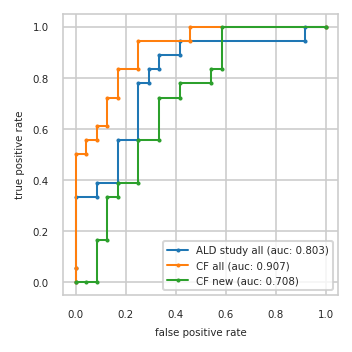

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.333  0.000 0.500  0.083 0.000
3          0.083 0.333  0.042 0.500  0.083 0.167
4          0.083 0.389  0.042 0.556  0.125 0.167
5          0.167 0.389  0.083 0.556  0.125 0.333
6          0.167 0.556  0.083 0.611  0.167 0.333
7          0.250 0.556  0.125 0.611  0.167 0.389
8          0.250 0.778  0.125 0.722  0.250 0.389
9          0.292 0.778  0.167 0.722  0.250 0.556
10         0.292 0.833  0.167 0.833  0.333 0.556
11         0.333 0.833  0.250 0.833  0.333 0.722
12         0.333 0.889  0.250 0.944  0.417 0.722
13         0.417 0.889  0.458 0.944  0.417 0.778
14         0.417 0.944  0.458 1.000  0.542 0.778
15         0.917 0.944  1.000 1.000  0.542 0.833
16         0.917 1.000    NaN   NaN  0.583 0.833
17         1.000 1.000    NaN   NaN  0.583 1.000
18           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P02766,P01011,P51688
2,A0A087WVV2;A0A0A0MRV0;Q9P2E9;Q9P2E9-2;V9GY78,P26447,E5RK69;E7EMC6;P08133;P08133-2
3,P61981,Q9Y2T3;Q9Y2T3-3,P31321
4,P04075,P51688,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P14174,P61981,A0A075B7B8
6,Q9Y2T3;Q9Y2T3-3,P04075,None
7,P00338;P00338-3,P14174,None
8,P25189;P25189-2,Q14894,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


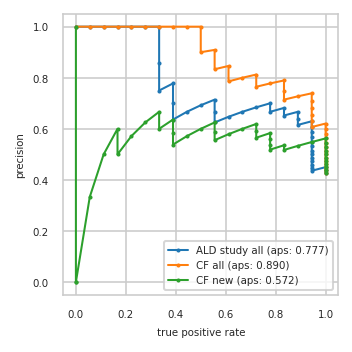

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.436 0.944     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.529 1.000
9          0.515 0.944     0.545 1.000     0.545 1.000
10         0.531 0.944     0.562 1.000     0.562 1.000
11         0.548 0.944     0.581 1.000     0.548 0.944
12         0.567 0.944     0.600 1.000     0.533 0.889
13         0.586 0.944     0.621 1.000     0.517 0.833
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.519 0.778
16         0.615 0.889     0.654 0.944     0.538 0.778
17         0.640 0.889     0.680 0.944     0.560 0.778
18         0.667 0.889     0.708 0.944     0.583 0.778
19         0.652 0.833     0.739 0.944     0.565 0.722
20         0.682 0.833     0.727 0.889     0.591 0.722
21         0.667 0.778     0.714 0.833     0.619 0.722
22         0.700 0.778     0.750 0.833     0.600 0.667
23         0.684 0.722     0.789 0.833     0.579 0.611
24         0.667 0.667     0.778 0.778     0.556 0.556
25         0.647 0.611     0.765 0.722     0.588 0.556
26         0.625 0.556     0.812 0.722     0.625 0.556
27         0.667 0.556     0.800 0.667     0.600 0.500
28         0.714 0.556     0.786 0.611     0.571 0.444
29         0.692 0.500     0.846 0.611     0.538 0.389
30         0.667 0.444     0.833 0.556     0.583 0.389
31         0.636 0.389     0.909 0.556     0.636 0.389
32         0.700 0.389     0.900 0.500     0.600 0.333
33         0.778 0.389     1.000 0.500     0.667 0.333
34         0.750 0.333     1.000 0.444     0.625 0.278
35         0.857 0.333     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


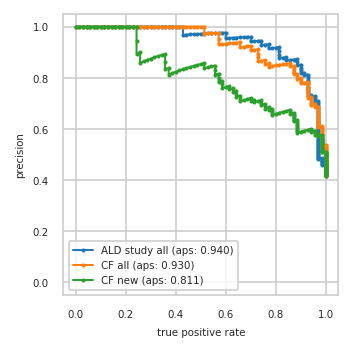

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


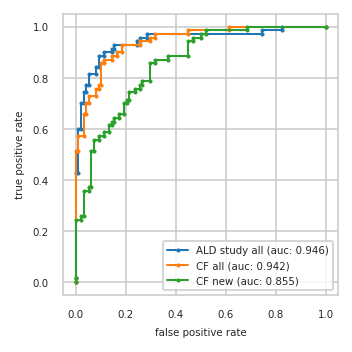

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}